# Details of machine learning and optimization
**Hands on: Optimising production of a hydro power plant**

## Instructions

PLEASE READ ALL INSTRUCTIONS EVEN IF YOU THINK THEY LOOK FAMILIAR FROM "INTRODUCTION TO MACHINE LEARNING". THEY ARE NOT THE SAME...

This is a jupyter notebook. You can run the code in each cell with "shift + enter" (or the run button above). Think of it as a script with blocks that can be run independently.

The notebook is running on a remote server. This means that you wont have to setup anything. When you are finished, you can save it to your own laptop under "File" and "Download as". However, in order to run locally you will also need the datafiles, python 3.6 or 3.7 and all the necessary packages (easily installed with anaconda).

The intention with this notebook is for you to get familiar with some more advanced details of machine learning and an example of how to combine it with optimization. Focus on the concepts rather than the code. 

The instructions for the exercises are given in orange text.

## Load the relevant python packages

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# numpy allows for efficient array operations
import numpy as np

# pandas is used to structure all data in data frames and do simple operations. Works well for datasets that are 
# sufficiently small they can be stored in memory.
import pandas as pd 

# scikit-learn contains simple and efficient tools for data mining and data analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Feature scaling
from sklearn.model_selection import train_test_split  # Splitting test and training data randomly
from sklearn.model_selection import cross_val_score  # Model evaluation
from sklearn.model_selection import RandomizedSearchCV  # Hyper parameter search
from sklearn.metrics import mean_squared_error  # Metric
from scipy.stats import randint, uniform

# keras is a high-level interface for deep learning. We will use tensorflow as backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Functions for this specific dataset. Feel free to have a look in the file aux_functions.py
from aux_functions import *

# We use Matplotlib pyplot for visualisation
import matplotlib.pyplot as plt
from IPython.display import Image

# seaborn provide useful statistical tools and quick visualisation
import seaborn as sns  

# We will use IPopt later for optimization
import cyipopt

# To see time impact
import time

plt.style.use('ggplot')

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.autograph.set_verbosity(0)

## The modelling challenge
Consider a hydro power plant with six generators each with a power output of ``P_i``. Each generator has a loss, $\Delta h_i^{head}$, which is related to the individual production of all generators in a complicated way. The **challenge is to optimise the power production while minimising the loss in the system**.

The strategy is to use simulated data to train a neural network to describe the relation between production and loss, and then use that in the optimisation.

In the figure below and in the data file, ``h_r1`` is the water level in the input reservoir, ``hr_2`` is the water level of the output reservoir. Part of the loss is above each turbine, $\Delta h_i^{head}$, and part of the loss is summed below the turbines $\Delta h^{tail}$.

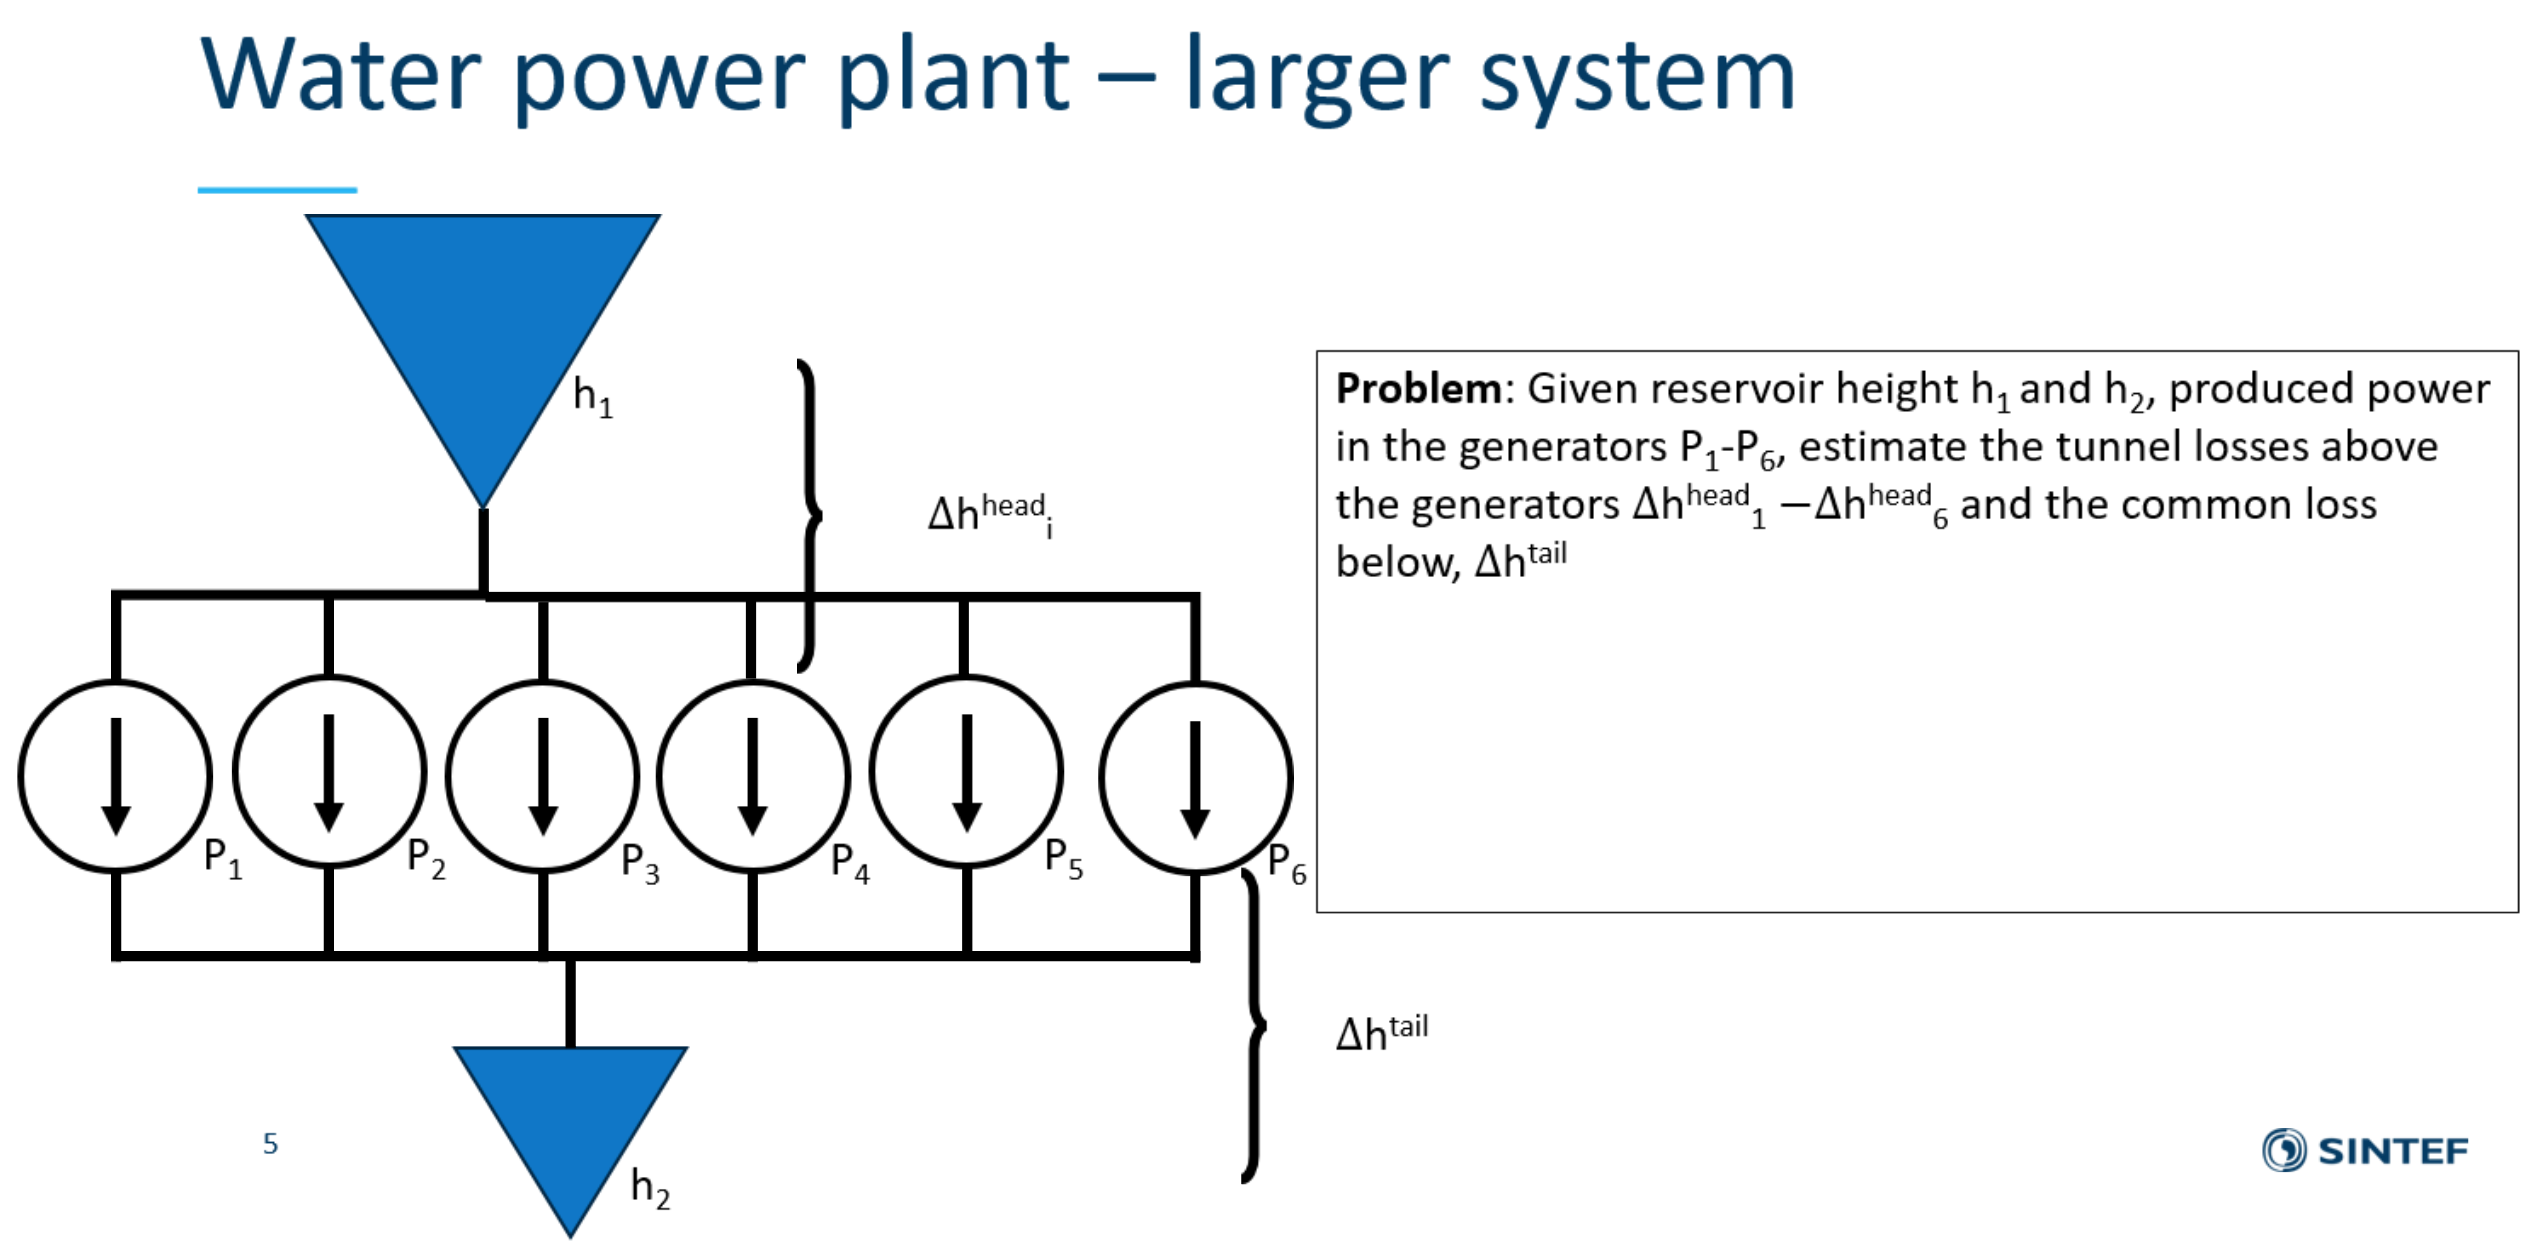

In [2]:
Image("./2res6turbines.png",  width=800)

## Data preprocessing

### Load data

In [3]:
file = 'plant_with_6_gen_tailrace_loss.h5'
data = load_data(file)
print(data.columns)
variables = ['h_r1', 'h_r2', 'P_0', 'loss_head_0', 'P_1', 'loss_head_1', 'P_2', 'loss_head_2', 
         'P_3', 'loss_head_3', 'P_4', 'loss_head_4', 'P_5', 'loss_head_5', 'loss_tail']

Index(['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'loss_head_0',
       'loss_head_1', 'loss_head_2', 'loss_head_3', 'loss_head_4',
       'loss_head_5', 'loss_tail'],
      dtype='object')


### Plotting the data
Visualisation and checking of data is very important. Always.

<span style="color:orange"> Visualise the data to check for outliers, faulty data, obvious parameter relations etc. Use jmin and jmax to zoom in on a smaller range of timesteps (jmin/jmax are bin/pixel numbers) </span>


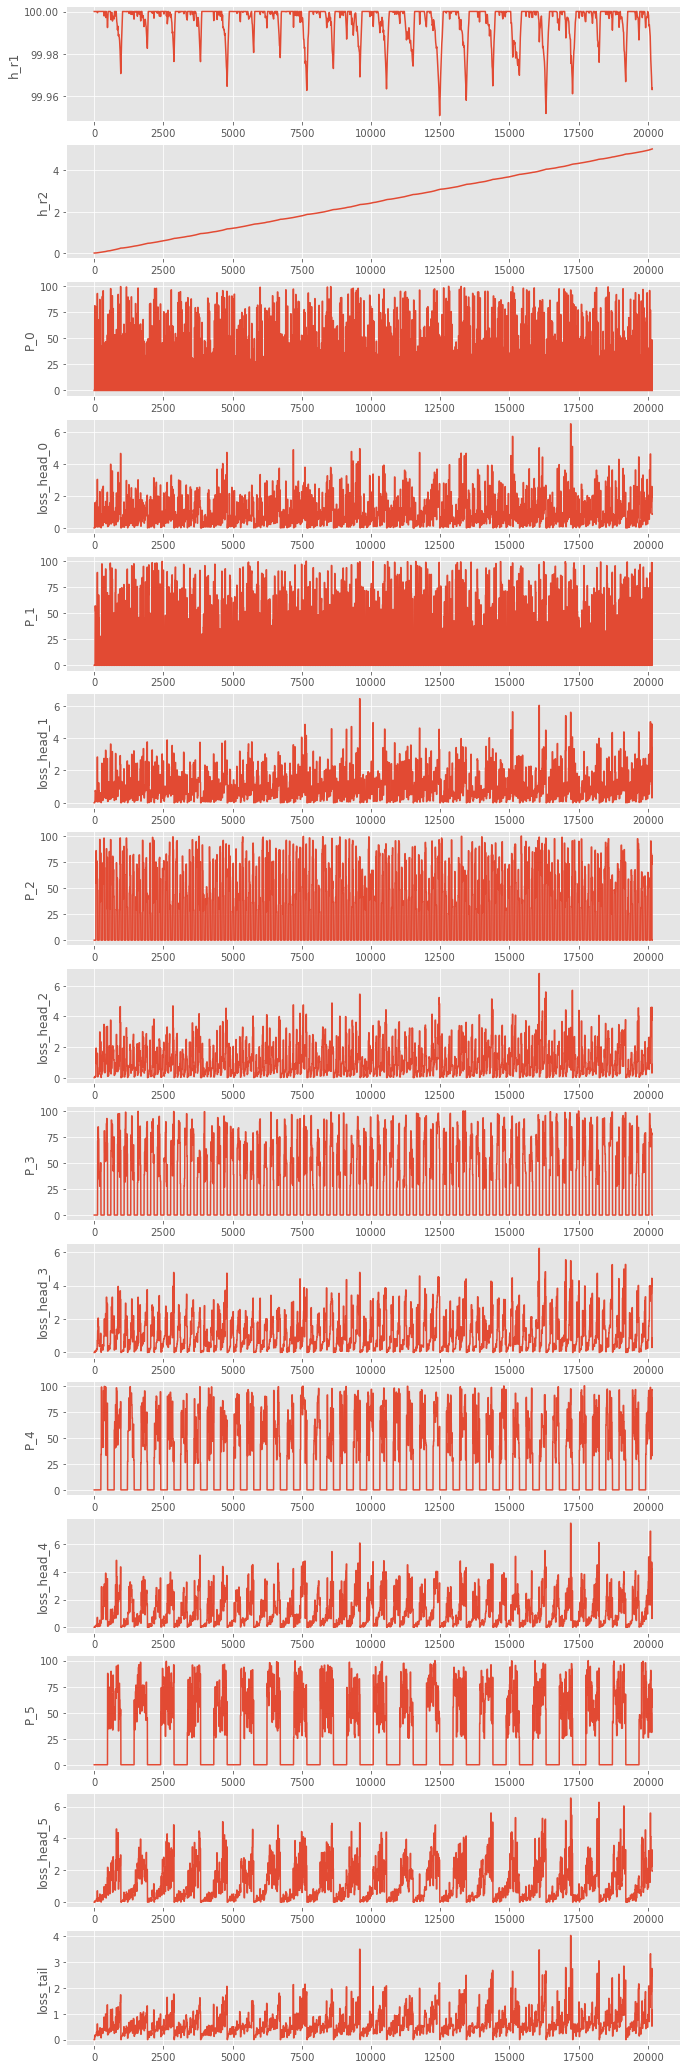

In [4]:
Nplots = len(variables)
jmin = 0      # minimum pixel number
jmax = -1      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots(Nplots, 1, figsize=(11,2.5*Nplots))

for i in range(Nplots):
    axs[i].plot(data[variables[i]].iloc[jmin:jmax])
    axs[i].set_ylabel(variables[i])   

### Additional visualisation and correlation
Normally we would always use a scatter plot and correlation matrix to check for dependencies and feature engineering, but in order to get to more interesting aspects, **today we will skip those steps**. The code is given below for future reference.

In [5]:
# Visualising data dependencies with seaborn, might take a while to run 
# Create the pairgrid object
#grid = sns.PairGrid(data=data, vars=variables, diag_sharey=False)

# Upper is a scatter plot
#grid.map_lower(plt.scatter, alpha=0.8, s=20)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)
# Bottom is density plot
#grid.map_upper(sns.kdeplot)
#plt.savefig('/gridmap.pdf')
#plt.show()

Parameter correlation is a quick way to check which parameters are important for the analysis. A trained eye will spot the correlations from the gridplot above, but still a quantification can be useful. We use a Spearman correlation since we don't know if the relationship between parameters is linear (Pearson correlation assumes linearity), and we're not interested in absolute values of correlations but rather the relative correlation.

In [6]:
# Create correlation matrix
#corr_matrix = data[variables].corr(method='spearman')
# Plot
#fig, axs = plt.subplots(1, 1, figsize=(10, 10))
#sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)

### Feature engineering and input/output features
We will use the heights and the individual power productions as input features, and the losses as output features. Since we want to optimise on the total loss, we will add it as an additional feature.

In [7]:
loss_list = ['loss_head_0', 'loss_head_1', 'loss_head_2', 
             'loss_head_3', 'loss_head_4', 'loss_head_5', 'loss_tail']
data['loss_tot'] = data[loss_list].sum(axis=1)  # summing all losses in each row

In [8]:
X_feat = ['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']
y_feat = ['loss_head_0', 'loss_head_1', 'loss_head_2', 
          'loss_head_3', 'loss_head_4', 'loss_head_5', 'loss_tail', 'loss_tot']
features = X_feat + y_feat

### Training and test data

Before we can train a model, we need to split the data in a training sample and a test sample.

We must also split out a sample to use for tuning the model. That is called the validation data. We want the validation to take place on chronological data rather than the randomized training data.

<span style="color:orange"> Chose the fraction of data to want to use for test and validation. </span>

In [9]:
train_frac = 0.2                # Fraction of total data for training
test_frac = 1 - train_frac      # Reserved for testing. Not used in training
val_frac = 0.2                  # Fraction of training data used during training for tuning of hyper parameters

In [10]:
train_split_index = int(train_frac*len(data))
val_split_index = int(val_frac*train_split_index) 
# We split out the validation data rather than using the validation_split variable in keras, since we want the 
# validation to take place on chronological data rather than the randomized training data

data_train = data.iloc[:train_split_index]
data_test = data.iloc[train_split_index:]
data_val = data.iloc[train_split_index-val_split_index:train_split_index]      

### Visualising the split (on the dependent features)

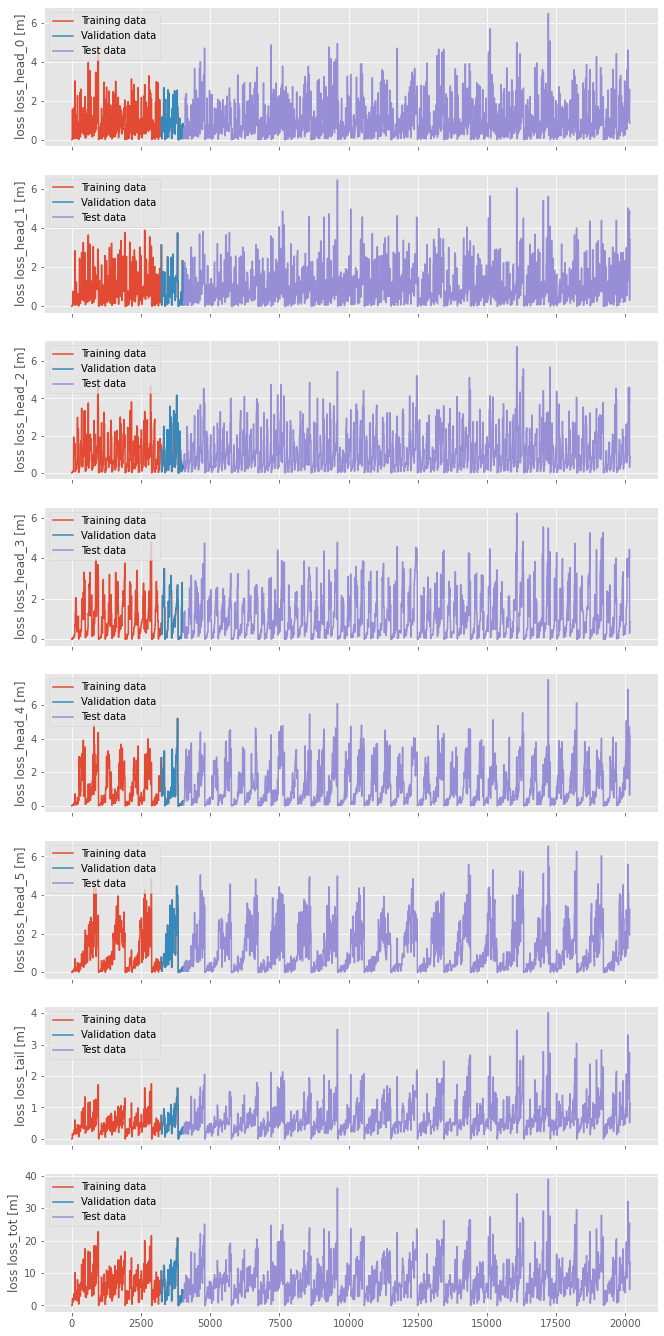

In [11]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(data_train[y_feat[i]], label='Training data')
    axs[i].plot(data_val[y_feat[i]], label='Validation data')
    axs[i].plot(data_test[y_feat[i]], label='Test data')
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()
        

In [12]:
X_train = data_train[X_feat]#.values
y_train = data_train[y_feat]#.values
X_val = data_val[X_feat]#.values
y_val = data_val[y_feat]#.values
X_test = data_test[X_feat]#.values
y_test = data_test[y_feat]#.values

In [13]:
print(np.shape(X_train))

(4032, 8)


### Feature scaling
Not all features have the same scale: Some have values of the order of 1000s, and some are 0.1. In order to let them equally influence the model, we need to "put everything on the same scale". We can either scale everything to a fixed range of values (MinMaxScaler) or change the distribution to become a normalised Gaussian (StandardScaler).

Depending on the sample size, the test data can either be scaled with their own scaling (for large samples), or with the training sample (small samples). What to chose depends on how you would treat the actual data you will later use with the model.

In [14]:
# Feature scaling
sc_X = MinMaxScaler(feature_range=[0,1])
sc_y = MinMaxScaler(feature_range=[0,1])
X_val_scaled = pd.DataFrame(sc_X.fit_transform(X_val), columns=X_feat)
y_val_scaled = pd.DataFrame(sc_y.fit_transform(y_val), columns=y_feat)
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train), columns=X_feat)
y_train_scaled = pd.DataFrame(sc_y.fit_transform(y_train), columns=y_feat)
X_test_scaled = pd.DataFrame(sc_X.transform(X_test), columns=X_feat)

## Neural network
<span style="color:orange"> Stop and wait for further instructions. </span>



### Defining the neural network
We use the keras framework with the Tensorflow backend to define the network (if you have no idea what that sentece was about, don't worry). 

The neural network itself will take the X-features as input and provide the y-estimates as output, but we also wrap it in a function that takes the number of neurons in each layer as input. The last parameter is dropout fraction which we apply to prevent overfitting.

In [15]:
def createModel(number_neurons1=10, number_neurons2=6, number_neurons3=4, dropout_frac=0.1):
    model = Sequential()
    model.add(Dense(units=number_neurons1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=number_neurons2, activation='relu'))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=number_neurons3, activation='relu'))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=y_train.shape[1], activation='linear'))

    model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
    return model

<span style="color:orange"> Chose the size of each layer and the dropout fraction by changing the values of the function parameters in the function call. </span>

In [16]:
model = createModel(number_neurons1=10, number_neurons2=6, number_neurons3=4, dropout_frac=0.1)

### Visualisation of a neural network
If you want to visualise the neural network, you can e.g. use http://alexlenail.me/NN-SVG/index.html

### Training the model
This may take a couple of minutes if the network is large. The figure below shows the loss computed on the training sample and the validation sample. The loss is the quantity the neural network aims to minimize.

The relevant hyper parameters are:

Epochs: The number of times the weights in the network will be updated. The value should be large enough for the network to converge (minimize loss to a stable level). If you run the training again without redefining the network, the training will continue from the previous session.

Batch size: Determines the number of samples for cross-validation. Generally you should use as small a batch size as patience/available computing time allows for.

Callbacks: A smart way to plot the loss during training. Requires the aux_functions.py

<span style="color:orange"> Chose some values for the hyper parameters and train the network </span>

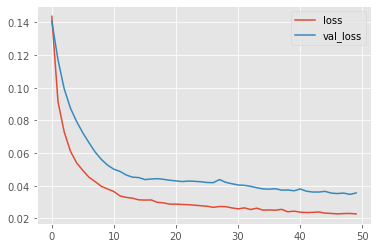

4032/4032 [==============================] - 0s 57us/sample - loss: 0.0228 - acc: 0.2525 - val_loss: 0.0356 - val_acc: 0.2370


In [17]:
training_history = model.fit(X_train_scaled, y_train_scaled, 
                             validation_data=(X_val_scaled, y_val_scaled), 
                             epochs=50,                  
                             batch_size=100,    
                             callbacks=[plot_losses])

### Using the model to predict the test data
Remember that we scaled the input and output data before training the model. Now we need to rescale the predictions before we compare to the actual values from the test data.

In [18]:
y_scaled = pd.DataFrame(model.predict(X_test_scaled), columns=y_feat)  # Predicting
y_pred = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

### Plotting the results
Compare the predicted results with the test data y values. 

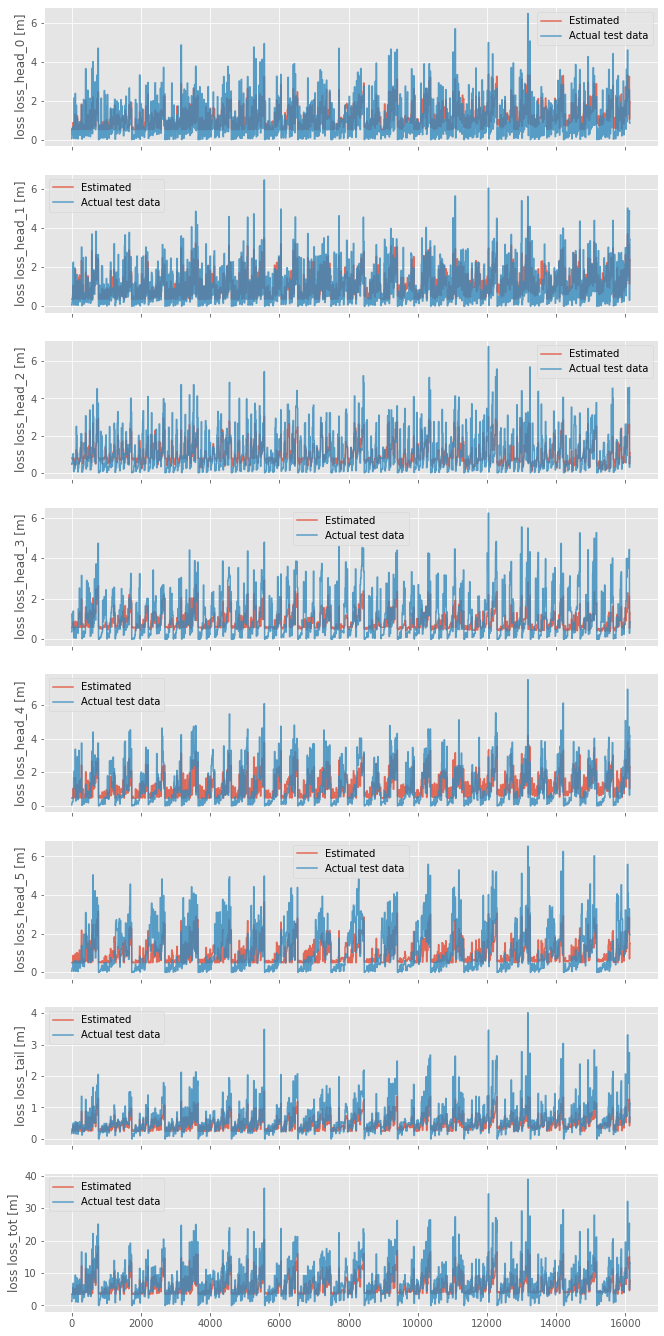

In [19]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(y_pred[y_feat[i]].values, label = 'Estimated', alpha=0.8) #  '.'
    axs[i].plot(y_test[y_feat[i]].values, label = 'Actual test data', alpha=0.8)  #'.'
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()

It seems that the network tends to underestimate higher value and overstimate lower values. This is typical of an error-minimisation/least-squares approach.

## Optmisation with the neural network
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Get the gradients
In order to optimise with the neural network, we need to get the gradients (derivatives) of the feature we would like to optimise, with respect to all the input features. We are here and in the following going to assume that `h_r1` and `h_r2` are constant, which is true enough if they are largely unaffected by what we do.

In [20]:
# This function may give a warning. Just ignore.
def get_gradients(model, inputs):
    features = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(features)
        predictions = model(features)
    gradients = tape.jacobian(predictions, features)
    return gradients

# Utility for visualizing optimization results
def plot_results(axs, init, found, obj):
    bound_palette = sns.dark_palette('brown')
    production_palette = sns.light_palette('green')
    turbine_palette = sns.color_palette()
    loss_palette = sns.light_palette('red')
    time_indices = np.array(range(obj.rows))
    
    for j in range(obj.free_cols):
        c = turbine_palette[j]
        axs[0].plot(time_indices, found[:,j], label=f'Turbine {j}', c = c)
        axs[0].plot(time_indices, init[:,j], c = c, linestyle = 'dotted')
    axs[0].legend(loc='upper left')
    axs[0].set_title('Production per turbine')
    
    # We will sum 
    axs[1].plot(time_indices, obj.lower_cons[:len(time_indices)], label='lower', c=bound_palette[0], linestyle='dotted')
    axs[1].plot(time_indices, obj.upper_cons[:len(time_indices)], label='upper', c=bound_palette[-1], linestyle='dotted')
    axs[1].plot(time_indices, init.sum(axis=1), label='orig prod', c=production_palette[2], linestyle='dashed')
    axs[1].plot(time_indices, found.sum(axis=1), label='opt prod', c=production_palette[-1])
    axs[1].legend(loc='upper left')
    axs[1].set_title('Total production')
    
    #This is a bit awkward, but no matter. The last output feature is total loss as seen above
    init_original_features = obj.to_internal(init.flatten())
    found_original_features = obj.to_internal(found.flatten())
    axs[2].plot(time_indices, obj.model(init_original_features).numpy()[:,-1], label ='orig loss', c = loss_palette[2], linestyle='dashed')
    axs[2].plot(time_indices, obj.model(found_original_features).numpy()[:,-1], label = 'opt loss', c = loss_palette[-1])
    axs[2].legend(loc='upper left')
    axs[2].set_title('Total loss')
    

### Simple optimization

The full code appears here, but as can be seen it is a little complex. The important part to understand is that we provide ipyopt with the objective and constraints, as well as their partial derivatives. 

<span style="color:orange"> For now, just execute the code... </span>

In [21]:
# We will be optimizing the pressures, but not the reservoir heights. They
# are assumed to be unaffected.

fixed_heights = X_test_scaled.values[:,:2]
initial_values = X_test_scaled.values[:,2:]

#We will also implement a basic class for this stuff
#Subclass must define constraints, jacobian, lower_bound, upper_bound, lower_cons, upper_cons, num_cons
class ModelBasedObjective(object):
    
    # Writing a more general handling of fixed columns is easy, but
    # ultimately unnecessary for us
    def __init__(self, rows, model, fixed, callback):
        self.rows = rows
        self.fixed_cols = 2
        self.free_cols = 6
        self.num_vars = self.rows * self.free_cols
        self.model = model
        self.fixed = fixed
        self.intermediate=callback
        
    def to_internal(self, xk):
        xk_shaped = xk.reshape(self.rows, self.free_cols)
        fixed = self.fixed[:self.rows,:]
        return np.concatenate((fixed, xk_shaped), axis=1)
    
    #Default adaptations if needed
    def objective(self, xk):
        return self.original_objective(self.to_internal(xk))
    
    def gradient(self, xk):
        return self._gradient(self.to_internal(xk))
    
    # Objective implementation
    def original_objective(self, x):
        objval = self.model(x).numpy()[:,-1].sum()
        return objval
    
    # Gradient implementation
    def _gradient(self, x):
        jacs = get_gradients(self.model, x)
        comb = jacs.numpy()[:,-1].sum(axis=0)[:,self.fixed_cols:]
        return comb.flatten()
    
def basic_callback(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
        if iter_count % 10 == 0:
            print(f'Iteration {iter_count}, val={obj_value}. inf_pr, inf_du, mu: {inf_pr:.2f}, {inf_du:.2f}, {mu:.2f}')   

In [22]:
# Define a simple problem

class SimpleProblemSparse(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper):
        super().__init__(rows, model, fixed, callback)
        
        # Each constraint sums a single row of the x interpreted in 2d,
        # so each gradient is zero outside of a single row, but then
        # everything needs to be flattened to work with cyipopt
        #We also need to set the bounds
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = np.array([prod_lower] * rows, dtype=np.float)
        self.upper_cons = np.array([prod_upper] * rows, dtype=np.float)
        self.num_cons = self.rows
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        
        self.jac = 1.0*np.ones(self.num_vars)
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return x.sum(axis=1)
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices

In [23]:
def optimize_model(obj, x0):  
    
    orig_obj = obj.objective(x0.flatten())
    
    print('Setting problem...')
    
    nlp = cyipopt.Problem(
                n = obj.num_vars,
                m = obj.num_cons,
                problem_obj = obj,
                lb = obj.lower_bound,
                ub = obj.upper_bound,
                cl = obj.lower_cons,
                cu = obj.upper_cons,
    )
    
    nlp.add_option('tol', 1e-2)
    print('Solving...')

    start = time.time()
    x, info = nlp.solve(x0.flatten())
    end = time.time()
    
    print(f'Initial value: {orig_obj}')
    print(f'Found value: {info["obj_val"]}')
    print(f'Status: {info["status"]}')
    print(f'Elapsed time: {end - start:.2f} seconds')
    
    #Reconstruct x with correct columns
    return x.reshape(obj.rows, obj.free_cols)

<span style="color:orange"> Try to change the lower or upper production values. </span>

Setting problem...
Solving...
Iteration 0, val=0.4639389216899872. inf_pr, inf_du, mu: 0.22, 0.00, 1.00
Initial value: 0.4639389216899872
Found value: 0.4639389216899872
Status: 0
Elapsed time: 1.68 seconds


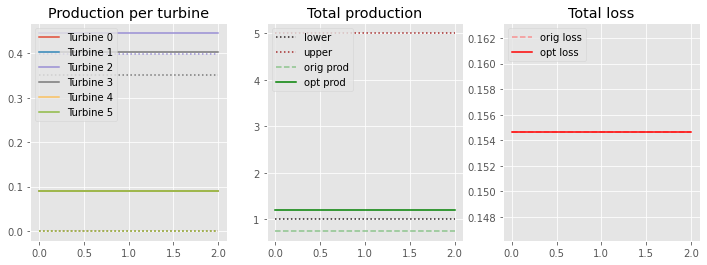

In [24]:
#Sparse time!
# Let's try with only three time steps first
tf.logging.set_verbosity(tf.logging.ERROR) #TODO remove this

rows = 3
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 5.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=0.4639389216899872. inf_pr, inf_du, mu: 0.22, 0.00, 1.00
Initial value: 0.4639389216899872
Found value: 0.4639389216899872
Status: 0
Elapsed time: 1.57 seconds


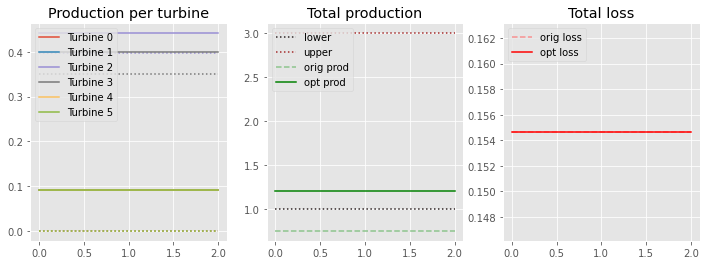

In [25]:
#Same with sparsity

#Reduce upper
rows = 3
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

<span style="color:orange"> For a more interesting case, try with 60 time steps. </span>

Setting problem...
Solving...
Iteration 0, val=10.699438095092773. inf_pr, inf_du, mu: 0.22, 0.20, 1.00
Initial value: 10.611879348754883
Found value: 9.278776168823242
Status: 0
Elapsed time: 1.70 seconds


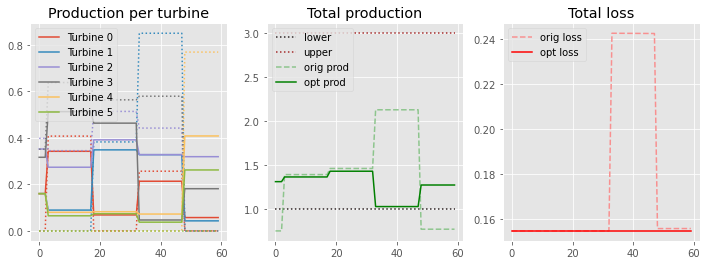

In [26]:
#Same with sparsity

rows = 60
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=9.278776168823242. inf_pr, inf_du, mu: 0.00, 0.00, 1.00
Initial value: 9.278776168823242
Found value: 9.278776168823242
Status: 0
Elapsed time: 1.13 seconds


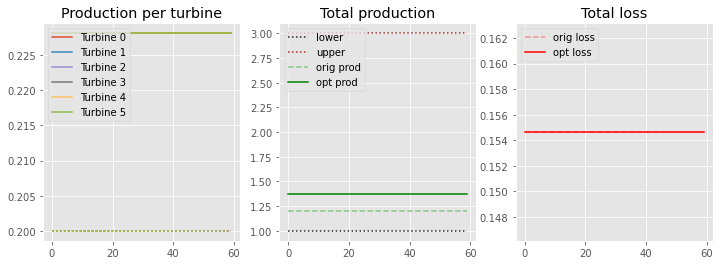

In [27]:
#Same with sparsity

rows = 60
init = 0.2*np.ones((60,6))

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

### With more realism

The model above is not realistic, for many reasons. We wish to extend the problem definition somewhat. Let's say we have a degree of flexibility in our production, so that we are rather trying to match the total historical production over the time frame. The problem is then to minimize the total loss, while producing at least this much (We will ignore time correction).

We can also add step constraints, and a time-varying production bound, but this will cause the model to be more complicated.

<span style="color:orange"> For now, just execute the code... </span>

In [28]:
# We will need to compute the historical production.
original_prod_per_time = initial_values.sum(axis=1)
# Now, for the first N time steps, the total production is original_prod_per_time[:N].sum()

In [29]:
# Utility for making sinusoidal production
def make_lower_prod(bottom, top, steps):
    args = np.arange(0,2*np.pi, step = 2*np.pi/steps)
    prod = ((1 - np.cos(args))/2.0) * (top - bottom) + bottom
    return prod

class TotalProductionBoundSparse(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper, total_prod):
        super().__init__(rows, model, fixed, callback)
        
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = np.array([prod_lower] * rows + [total_prod], dtype=np.float)
        self.upper_cons = np.array([prod_upper] * rows + [self.free_cols * self.rows], dtype=np.float)
        self.num_cons = self.rows + 1
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)
        # Now append the last row, which has an index for every variable
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(self.rows)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        self.jac = np.concatenate((1.0*np.ones(self.num_vars), 1.0*np.ones(self.num_vars)))
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return np.concatenate((x.sum(axis=1), [x.sum()]))
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices


<span style="color:orange"> Experiment with different conditions </span>

Setting problem...
Solving...
Iteration 0, val=10.699438095092773. inf_pr, inf_du, mu: 0.00, 0.15, 1.00
Initial value: 10.611879348754883
Found value: 9.278776168823242
Status: 0
Elapsed time: 2.28 seconds


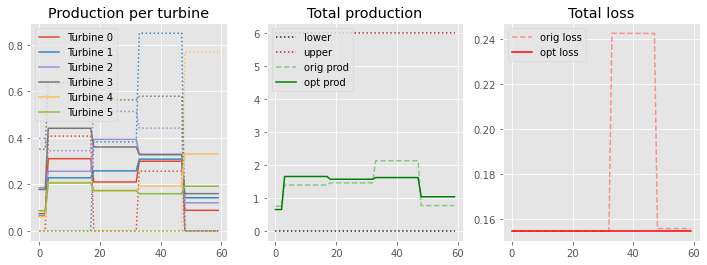

In [30]:
#Strict curve
rows = 60
init = initial_values[:rows,:]

obj = TotalProductionBoundSparse(rows, model, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=19.306303024291992. inf_pr, inf_du, mu: 0.00, 0.24, 1.00
Initial value: 19.306303024291992
Found value: 9.278776168823242
Status: 0
Elapsed time: 1.32 seconds


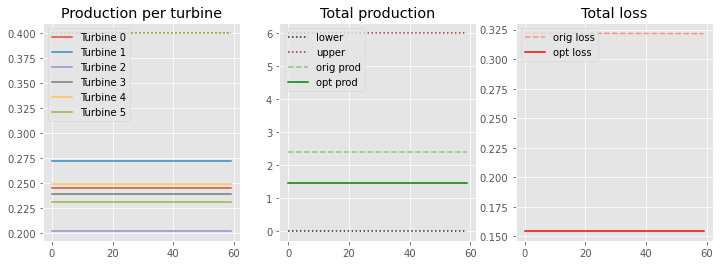

In [31]:
rows = 60
init = 0.4* np.ones((rows, 6))

obj = TotalProductionBoundSparse(rows, model, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=3.092926502227783. inf_pr, inf_du, mu: 0.00, 0.00, 1.00
Initial value: 3.092926502227783
Found value: 3.092926502227783
Status: 0
Elapsed time: 1.37 seconds


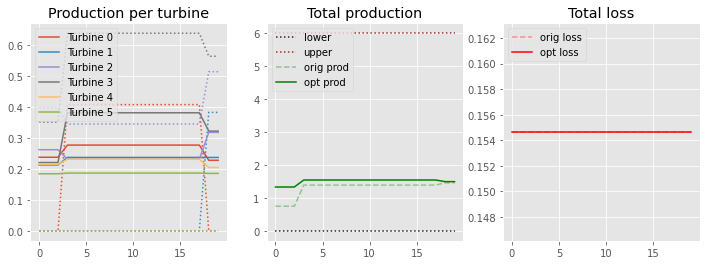

In [32]:
# With sparsity
#Strict curve
rows = 20
init = initial_values[:rows,:]

obj = TotalProductionBoundSparse(rows, model, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

In [53]:
# Define a simple problem

class TimeVaryingProductionBound(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper):
        super().__init__(rows, model, fixed, callback)
        
        # Each constraint sums a single row of the x interpreted in 2d,
        # so each gradient is zero outside of a single row, but then
        # everything needs to be flattened to work with cyipopt
        #We also need to set the bounds
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = prod_lower
        self.upper_cons = prod_upper
        self.num_cons = self.rows
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        
        self.jac = 1.0*np.ones(self.num_vars)
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return x.sum(axis=1)
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices

Setting problem...
Solving...
Iteration 0, val=3.092926502227783. inf_pr, inf_du, mu: 0.00, 0.00, 1.00
Initial value: 3.092926502227783
Found value: 3.092926502227783
Status: 0
Elapsed time: 1.18 seconds


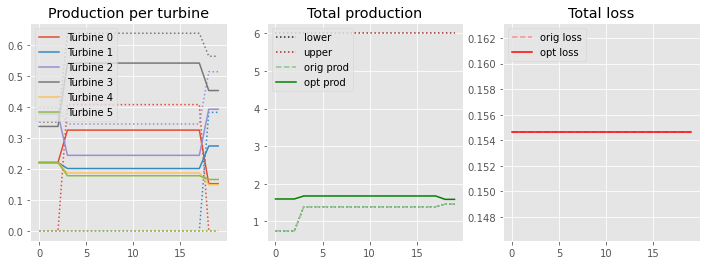

In [54]:
# Historically accurate production
rows = 20
init = initial_values[:rows,:]

obj = TimeVaryingProductionBound(rows, model, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=10.699438095092773. inf_pr, inf_du, mu: 0.00, 0.20, 1.00
Iteration 10, val=9.869170188903809. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 20, val=9.842436790466309. inf_pr, inf_du, mu: 0.00, 0.11, 0.00
Iteration 30, val=9.762749671936035. inf_pr, inf_du, mu: 0.00, 0.10, 0.00
Iteration 40, val=9.743000030517578. inf_pr, inf_du, mu: 0.00, 0.12, 0.00
Iteration 50, val=9.741949081420898. inf_pr, inf_du, mu: 0.00, 0.10, 0.00
Iteration 60, val=9.739889144897461. inf_pr, inf_du, mu: 0.00, 0.08, 0.00
Iteration 70, val=9.739470481872559. inf_pr, inf_du, mu: 0.00, 0.08, 0.00
Iteration 80, val=9.739527702331543. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 90, val=9.739429473876953. inf_pr, inf_du, mu: 0.00, 0.09, 0.00
Iteration 100, val=9.739410400390625. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 110, val=9.739404678344727. inf_pr, inf_du, mu: 0.00, 0.10, 0.00
Iteration 120, val=9.739404678344727. inf_pr, inf_du, mu: 0.00, 0.10, 0.00
Itera

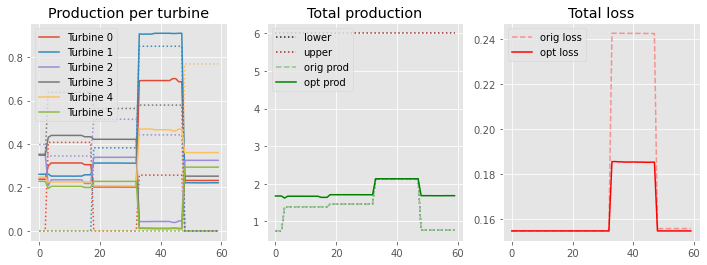

In [55]:
# Historically accurate production
rows = 60
init = initial_values[:rows,:]

obj = TimeVaryingProductionBound(rows, model, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=19.306303024291992. inf_pr, inf_du, mu: 0.00, 0.21, 1.00
Iteration 10, val=9.877363204956055. inf_pr, inf_du, mu: 0.00, 0.04, 0.00
Iteration 20, val=9.737667083740234. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 30, val=9.729813575744629. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 40, val=9.700968742370605. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 50, val=9.694928169250488. inf_pr, inf_du, mu: 0.00, 0.12, 0.00
Iteration 60, val=9.698591232299805. inf_pr, inf_du, mu: 0.00, 0.09, 0.00
Iteration 70, val=9.698958396911621. inf_pr, inf_du, mu: 0.00, 0.01, 0.00
Iteration 80, val=9.69898509979248. inf_pr, inf_du, mu: 0.00, 0.14, 0.00
Iteration 90, val=9.698976516723633. inf_pr, inf_du, mu: 0.00, 0.14, 0.00
Iteration 100, val=9.698966979980469. inf_pr, inf_du, mu: 0.00, 0.14, 0.00
Iteration 110, val=9.698966979980469. inf_pr, inf_du, mu: 0.00, 0.14, 0.00
Initial value: 19.306303024291992
Found value: 9.698966979980469
Status: -2
Elaps

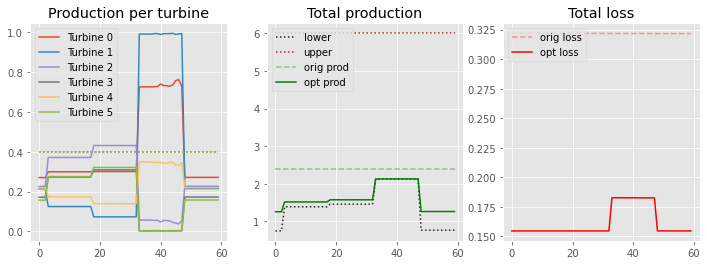

In [56]:
# Historically accurate production
rows = 60
init = 0.4 * np.ones((rows,6))

obj = TimeVaryingProductionBound(rows, model, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

## Evaluation of model performance
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Evaluating the cross-validation scores
One way to quantify if the neural network provides a reasonable fit is to compute the mean squared error on multiple splots of the test data (cross-validation). ScikitLearn has a function for that, which returns the score for each of the data splits. If the mean squared error is small, the model is a good fit to the data. If the variation is small, the model has also managed to generalise the information in the data. (For technical reasons ScikitLearn uses negative mean squared error).

<span style="color:orange"> Is your model good? </span>

In [33]:
scores = cross_val_score(KerasRegressor(build_fn=createModel, nb_epoch=30, verbose=0), 
                         X_test_scaled, y_test,  cv=5, scoring="neg_mean_squared_error")
print(scores*-1)

[ 3.51992962  6.27675159  1.8471658   3.81700508 15.3694488 ]


## Hyperparameter optimization
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Manual

<span style="color:orange"> Try different values for the hyper parameters by replacing the values below </span>

In [34]:
dropout_frac = 0      # fraction between 0 and 1
number_neurons1 = 5   # integer
number_neurons2 = 6   # integer
number_neurons3 = 7   # integer

In [35]:
model2 = createModel(dropout_frac=dropout_frac, 
                     number_neurons1=number_neurons1, 
                     number_neurons2=number_neurons2, 
                     number_neurons3=number_neurons3)

### Randomized search
Manually searching through hyper parameters isn't very effective. Instead we will use an option called randomized search, where we specify some ranges for the hyper parameters.

<span style="color:orange"> Set some ranges for the layer sizes and search through the hyper parameter space. This may take a while, so we just run a very small grid with few iterations and cross-validations. </span>

In [36]:
param_dist = {"number_neurons1": randint(4, 6),
              "number_neurons2": randint(7, 8),
              "number_neurons3": randint(4, 6),
              "dropout_frac": [0, 0.1, 0.2]}

In [37]:
# In order to use randomized searh we need to define our model as a regressor
k_model = KerasRegressor(build_fn=createModel, verbose=0)

In [38]:
# Define the search
random_search = RandomizedSearchCV(k_model, param_distributions=param_dist,                   
                                   scoring = "neg_mean_squared_error",
                                   n_iter=1, cv=2)

In [39]:
# Run the search
random_search.fit(X_train_scaled, y_train_scaled,
                  validation_data=(X_val_scaled, y_val_scaled),
                  epochs=30, batch_size=100, verbose=2)

Train on 2016 samples, validate on 806 samples
Epoch 1/30
2016/2016 - 0s - loss: 0.1899 - acc: 0.1463 - val_loss: 0.1744 - val_acc: 0.1452
Epoch 2/30
2016/2016 - 0s - loss: 0.1335 - acc: 0.1389 - val_loss: 0.1462 - val_acc: 0.0732
Epoch 3/30
2016/2016 - 0s - loss: 0.1053 - acc: 0.1582 - val_loss: 0.1298 - val_acc: 0.1117
Epoch 4/30
2016/2016 - 0s - loss: 0.0907 - acc: 0.1696 - val_loss: 0.1183 - val_acc: 0.1675
Epoch 5/30
2016/2016 - 0s - loss: 0.0809 - acc: 0.1920 - val_loss: 0.1092 - val_acc: 0.1489
Epoch 6/30
2016/2016 - 0s - loss: 0.0734 - acc: 0.1935 - val_loss: 0.1021 - val_acc: 0.1489
Epoch 7/30
2016/2016 - 0s - loss: 0.0680 - acc: 0.1895 - val_loss: 0.0964 - val_acc: 0.1675
Epoch 8/30
2016/2016 - 0s - loss: 0.0634 - acc: 0.1870 - val_loss: 0.0917 - val_acc: 0.1675
Epoch 9/30
2016/2016 - 0s - loss: 0.0597 - acc: 0.1895 - val_loss: 0.0875 - val_acc: 0.1861
Epoch 10/30
2016/2016 - 0s - loss: 0.0569 - acc: 0.1890 - val_loss: 0.0842 - val_acc: 0.1861
Epoch 11/30
2016/2016 - 0s - los

Epoch 28/30
4032/4032 - 0s - loss: 0.0229 - acc: 0.2272 - val_loss: 0.0293 - val_acc: 0.2556
Epoch 29/30
4032/4032 - 0s - loss: 0.0221 - acc: 0.2369 - val_loss: 0.0283 - val_acc: 0.2556
Epoch 30/30
4032/4032 - 0s - loss: 0.0220 - acc: 0.2440 - val_loss: 0.0282 - val_acc: 0.2742


RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7c6b541c90>,
                   n_iter=1,
                   param_distributions={'dropout_frac': [0, 0.1, 0.2],
                                        'number_neurons1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c6b5a0fd0>,
                                        'number_neurons2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c6b541410>,
                                        'number_neurons3': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c6b5416d0>},
                   scoring='neg_mean_squared_error')

In [40]:
# Print the best score from the random search
random_search.best_score_*-1

0.034573927850439216

<span style="color:orange"> Compare to the score you got for manual search </span>

In [41]:
# Print the best parameters
random_search.best_params_

{'dropout_frac': 0.1,
 'number_neurons1': 4,
 'number_neurons2': 7,
 'number_neurons3': 5}

<span style="color:orange"> Compare to the network sizes you had before. Is the fit better now? </span>

In reality we would run a larger grid, so if you didn't get any improvement, you can try with 

best_params = {'dropout_frac': 0.1, 'number_neurons1': 18, 'number_neurons2': 10, 'number_neurons3': 12}

### Visualising the new model

In [43]:
y_scaled = pd.DataFrame(random_search.predict(X_test_scaled), columns=y_feat)  # Predicting
y_pred = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

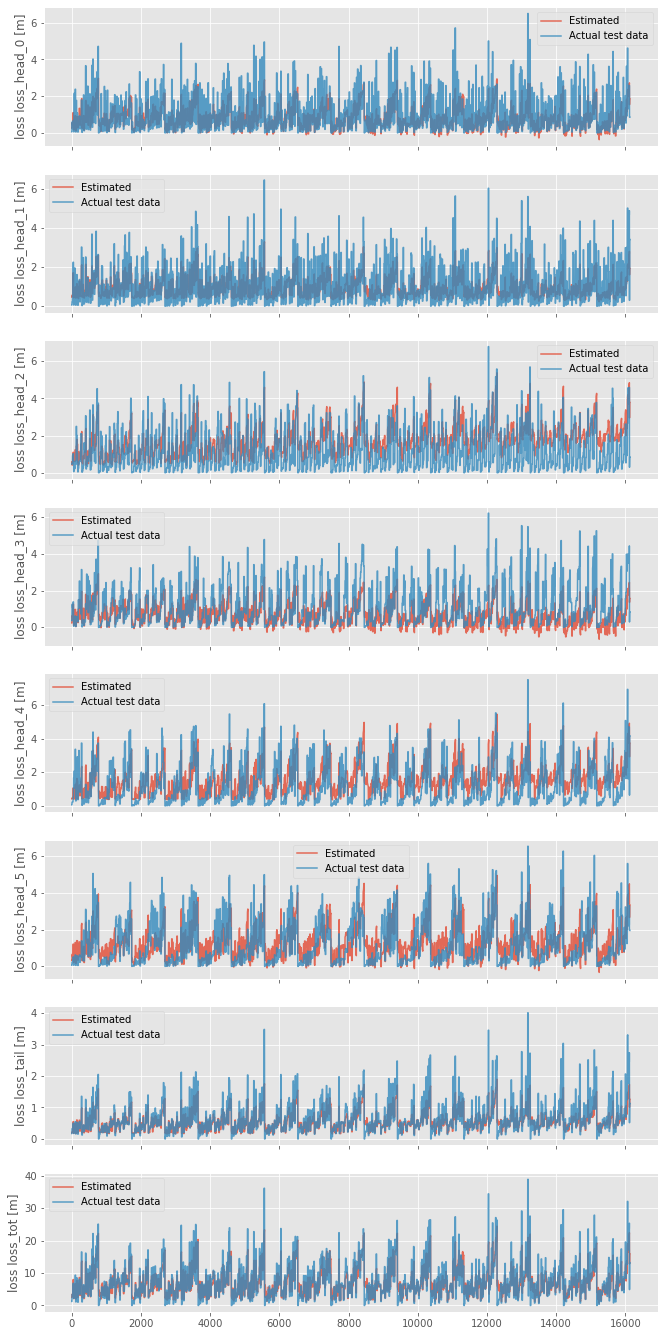

In [44]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(y_pred[y_feat[i]].values, label = 'Estimated', alpha=0.8) 
    axs[i].plot(y_test[y_feat[i]].values, label = 'Actual test data', alpha=0.8)     
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()

## Optimisation with better model

Let's try this again.

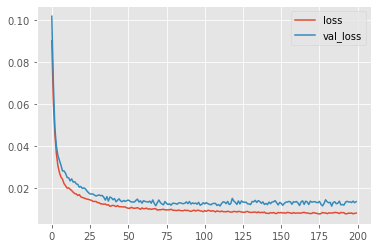

4032/4032 [==============================] - 0s 69us/sample - loss: 0.0082 - acc: 0.6724 - val_loss: 0.0136 - val_acc: 0.7320


In [57]:
# We must train a model with the best hyperparameters from the random search
#model2 = createModel(dropout_frac=random_search.best_params_['dropout_frac'], 
#                     number_neurons1=random_search.best_params_['number_neurons1'],
#                     number_neurons2=random_search.best_params_['number_neurons2'],
#                     number_neurons3=random_search.best_params_['number_neurons3'])

dropout_frac = 0.1      # fraction between 0 and 1
number_neurons1 = 18   # integer
number_neurons2 = 10   # integer
number_neurons3 = 12   # integer

model2 = createModel(dropout_frac=dropout_frac, 
                     number_neurons1=number_neurons1, 
                     number_neurons2=number_neurons2, 
                     number_neurons3=number_neurons3)

training_history = model2.fit(X_train_scaled, y_train_scaled, 
                             validation_data=(X_val_scaled, y_val_scaled), 
                             epochs=200,                  
                             batch_size=100,    
                             callbacks=[plot_losses])

<span style="color:orange"> Try some of the same snippets as before. Are the results different? </span>

Setting problem...
Solving...
Iteration 0, val=16.067651748657227. inf_pr, inf_du, mu: 0.00, 0.25, 1.00
Iteration 10, val=2.2786335945129395. inf_pr, inf_du, mu: 0.00, 0.01, 0.00
Iteration 20, val=2.2540431022644043. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 30, val=2.25307297706604. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 40, val=2.252985954284668. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 50, val=2.2529478073120117. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 60, val=2.2529115676879883. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Iteration 70, val=2.2528903484344482. inf_pr, inf_du, mu: 0.00, 0.05, 0.00
Initial value: 16.067651748657227
Found value: 2.2528741359710693
Status: 0
Elapsed time: 17.95 seconds


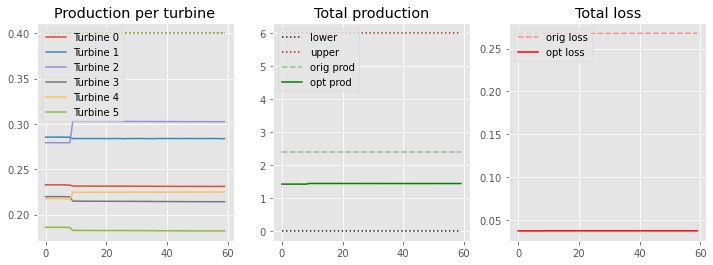

In [58]:
# With total production bound

rows = 60
init = 0.4* np.ones((rows, 6))

obj = TotalProductionBoundSparse(rows, model2, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=16.067651748657227. inf_pr, inf_du, mu: 0.00, 0.22, 1.00
Iteration 10, val=4.4322075843811035. inf_pr, inf_du, mu: 0.00, 0.18, 0.00
Iteration 20, val=4.379889488220215. inf_pr, inf_du, mu: 0.00, 0.31, 0.00
Iteration 30, val=4.377066135406494. inf_pr, inf_du, mu: 0.00, 0.29, 0.00
Iteration 40, val=4.3753252029418945. inf_pr, inf_du, mu: 0.00, 0.19, 0.00
Iteration 50, val=4.370904922485352. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 60, val=4.368218898773193. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 70, val=4.367538928985596. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 80, val=4.367385387420654. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 90, val=4.367177963256836. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 100, val=4.367084503173828. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 110, val=4.367057800292969. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 120, val=4.367048263549805. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Ite

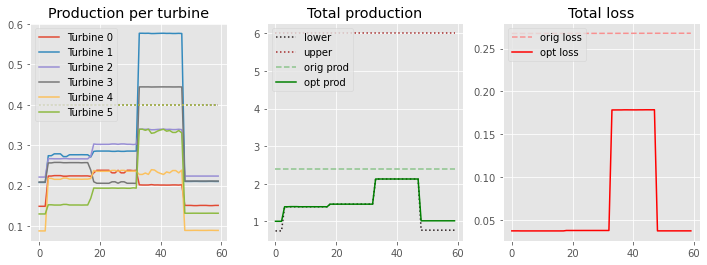

In [59]:
# Historically accurate production, starting from 0.4
rows = 60
init = 0.4 * np.ones((rows,6))

obj = TimeVaryingProductionBound(rows, model2, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=10.474038124084473. inf_pr, inf_du, mu: 0.00, 0.44, 1.00
Iteration 10, val=4.450279712677002. inf_pr, inf_du, mu: 0.00, 0.21, 0.00
Iteration 20, val=4.385820388793945. inf_pr, inf_du, mu: 0.00, 0.04, 0.00
Iteration 30, val=4.382524013519287. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Iteration 40, val=4.377842426300049. inf_pr, inf_du, mu: 0.00, 0.19, 0.00
Iteration 50, val=4.375597953796387. inf_pr, inf_du, mu: 0.00, 0.23, 0.00
Iteration 60, val=4.371696949005127. inf_pr, inf_du, mu: 0.00, 0.18, 0.00
Iteration 70, val=4.369418144226074. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 80, val=4.368870258331299. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 90, val=4.368725776672363. inf_pr, inf_du, mu: 0.00, 0.20, 0.00
Iteration 100, val=4.3686699867248535. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
Iteration 110, val=4.36857271194458. inf_pr, inf_du, mu: 0.00, 0.19, 0.00
Iteration 120, val=4.368488311767578. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
Itera

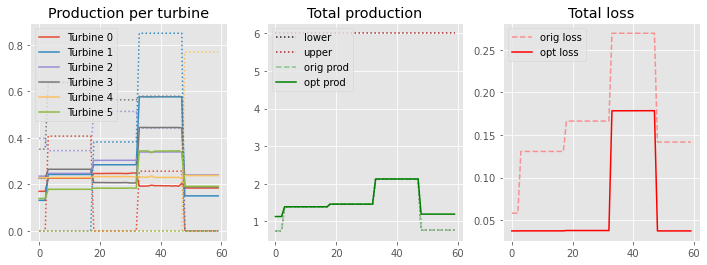

In [60]:
# Historically accurate production, starting from history
rows = 60
init = initial_values[:rows,:]

obj = TimeVaryingProductionBound(rows, model2, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)